## **Imports**

In [18]:
import os
import joblib
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

## **Paths & Global Variables**

In [19]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR, MODELS_DIR

## **Reading Data**

In [20]:
os.chdir(PROCESSED_DATA_DIR)

features_selected = pd.read_json("knn_features.json").index.to_list()

X_train = pd.read_parquet("X_train.parquet", columns=features_selected)
y_train = pd.read_parquet("y_train.parquet")

X_test = pd.read_parquet("X_val.parquet", columns=features_selected)
y_test = pd.read_parquet("y_val.parquet")

# **K-Nearest Neighbors**

In [21]:
cols_to_remove = [
    "passenger_class_ord",
    "num_rooms",
    "title_lcode",
    "cabin_level_1_B",
    "cabin_level_1_E",
    "cabin_level_1_D",
]
X_train.drop(columns=cols_to_remove, inplace=True)
X_test.drop(columns=cols_to_remove, inplace=True)

## **Model Fitting**

<Axes: >

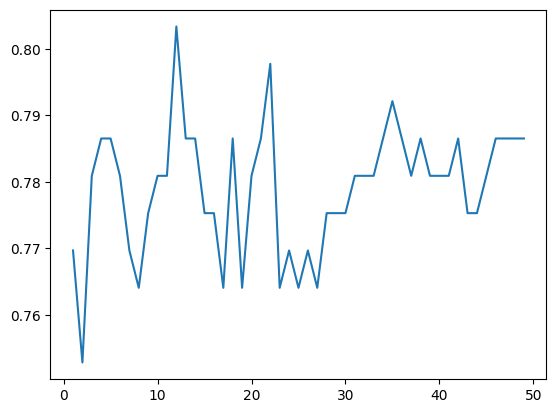

In [22]:
k_values = list(range(1, 50))
k_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.values.ravel())
    k_scores.append(knn.score(X_test, y_test))

sns.lineplot(x=k_values, y=k_scores)

In [23]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=12)

## **Model Testing**

In [24]:
y_predicted = knn.predict(X_test)
y_predicted_probs = knn.predict_proba(X_test)[:, 1]

In [25]:
y_predicted_df = pd.DataFrame(y_predicted, columns=["predicted"], index=X_test.index)
y_predicted_probs_df = pd.DataFrame(
    y_predicted_probs, columns=["probability"], index=X_test.index
)
y_predicted_df = pd.concat([y_predicted_df, y_predicted_probs_df], axis=1)
y_predicted_df.head()

,predicted,probability
passenger_id,,
161,False,0.000000
127,False,0.250000
429,False,0.250000
423,False,0.083333
566,False,0.083333


## **Evaluation Metrics**

In [26]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,95,15
actual yes,20,48


In [27]:
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_predicted),
    "Precision": precision_score(y_test, y_predicted),
    "Recall": recall_score(y_test, y_predicted),
    "F1 Score": f1_score(y_test, y_predicted),
}

metrics_df = pd.DataFrame(
    metrics_dict.values(), index=metrics_dict.keys(), columns=["Value"]
)

roc_auc = roc_auc_score(y_test, y_predicted_probs)
gini = 2 * roc_auc - 1

metrics_df.loc["ROC AUC"] = roc_auc
metrics_df.loc["Gini"] = gini

metrics_df

,Value
Accuracy,0.803371
Precision,0.761905
Recall,0.705882
F1 Score,0.732824
ROC AUC,0.815909
Gini,0.631818


## **Model & Prediction Export**

In [28]:
os.chdir(MODELS_DIR)
# Save model
joblib.dump(knn, "knn-model.joblib")
y_predicted_df.to_parquet("knn-y_predicted.parquet")